# Getting started with Task 3

Download the dataset from the [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106) using the script `download_intracardiac_dataset.sh`:

```bash
source download_intracardiac_dataset.sh
```

## Load Modules and Preprocessing Functions

Load modules and preprocessing functions.

In [1]:
import glob, re, os
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import random

Load the `cardiac_ml_tools` module.

In [2]:
%run cardiac_ml_tools.py

## Load the dataset

In [3]:
data_dirs = []
regex = r'data_hearts_dd_0p2*'
DIR='../intracardiac_dataset/' # This should be the path to the intracardiac_dataset, it can be downloaded using data_science_challenge_2023/download_intracardiac_dataset.sh
for x in os.listdir(DIR): # os.listdir gets all the folders in a directory
    if re.match(regex, x):
        data_dirs.append(DIR + x)
file_pairs = read_data_dirs(data_dirs)
print('Number of file pairs: {}'.format(len(file_pairs)))
# example of file pair
print("Example of file pair:")
print("{}\n{}".format(file_pairs[0][0], file_pairs[0][1]))

Number of file pairs: 16117
Example of file pair:
../intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/pECGData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.000.pattern.0.volunteer.v12.npy
../intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/VmData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.000.pattern.0.volunteer.v12.npy


## Normalize ECG Data

In [4]:
def normalize_ecg(ecg):
        normalized_ecg = np.zeros_like(ecg)
        for i in range(ecg.shape[0]):
            lead_min = np.min(ecg[i])
            lead_max = np.max(ecg[i])
            lead_range = lead_max - lead_min
            
            if lead_range != 0:
                normalized_ecg[i] = (ecg[i] - lead_min) / lead_range
            else:
                normalized_ecg[i] = ecg[i] - lead_min  # If the lead is constant, just center it at 0
        return normalized_ecg

## Dataset details

The dataset [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106) 
consists of pairs of computationally simulated intracardiac transmembrane voltage recordings and ECG signals.
In total, 16140 organ-level simulations were conducted to create this dataset.
Simulations were performed using Lassen supercomputer at Lawrence Livermore National Lab (LLNL), concurrently utilizing 4 GPUs and 40 CPU cores.
Each simulation produced pairs of 500ms-by-10 raw electrode signals and 500ms-by-75 transmembrane voltage signals.
For convenience, we collect those signals in matrices and give them the following names:

Tensor | Description | Shape | Notes
--- | --- | --- | ---
$X$ | Row electrode signals | $10 \times 500$ | 10-lead ECG signals from the simulated torso (in [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106))
$V$ | Activation map | $75 \times 500$ | Transmembrane voltage signals from the simulated heart (in [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106))
$E$ | 12-lead ECG signals | $12 \times 500$ | 12-lead ECG signals obtained by `get_standard_leads`($X$)
$A$ | Activation map | $75 \times 1$ | Activation time, defined as $A_i = \text{min}_j(V_{ij})$

**IMPORTANT** : The raw data in the dataset consists of 10-lead ECG signals and 75-lead transmembrane voltage signals. The 12-lead ECG signals are obtained from the 10-lead ECG signals using the function `get_standard_leads` (in the file `cardiac_ml_tools.py`).

The overall generation process is shown in the following image. The ECG signal is recorded using 10 virtual electrodes and the transmembrane voltages are recorded at 75 points within the myocardium. The transmembrane voltages are then used to generate the spatio-temporal activation maps.

![ECG 10 2 12](../figures/data_generation.png)

## Getting the standard 12-lead ECG from the 10-lead ECG

The function `get_standard_leads` (in the file `cardiac_ml_tools.py`) is used to obtain the 12-lead ECG signals from the 10-lead ECG signals. It implements the following transformation, where the (Wilson Lead) is defined as $Vw = 1/3*(RA + LA + LL)$:
$$
\left\{
\begin{array}{lll}
    X_{:,1}  & \to  & RA \\
    X_{:,2}  & \to  & LA \\
    X_{:,3}  & \to  & LL \\
    X_{:,4}  & \to  & RL \\
    X_{:,5}  & \to  & V1 \\
    X_{:,6}  & \to  & V2 \\
    X_{:,7}  & \to  & V3 \\
    X_{:,8}  & \to  & V4 \\
    X_{:,9}  & \to  & V5 \\
    X_{:,10} & \to &  V6 \\
\end{array}
\right.
\text{        and        }
\left\{
\begin{array}{lll}          
\text{Lead } I& : & LA - RA \\
\text{Lead } II& : & LL - RA \\
\text{Lead } III& : & LL - LA \\
\text{Lead } aVR& : &  \frac{3}{2} (RA - Vw) \\
\text{Lead } aVL& : &  \frac{3}{2} (LA - Vw) \\
\text{Lead } aVF& : &  \frac{3}{2} (LL - Vw)\\ 
\text{Lead } V1 & : & V1 - Vw \\
\text{Lead } V2 & : & V2 - Vw \\
\text{Lead } V3 & : & V3 - Vw \\
\text{Lead } V4 & : & V4 - Vw \\
\text{Lead } V5 & : & V5 - Vw \\
\text{Lead } V6 & : & V6 - Vw \\
\end{array}
\right.
$$

In [5]:
# Example of file pair
# ECG plot
row = 3 
column = 4
num_timesteps = 500
plt.figure(figsize=(10, 7))

titles = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
reorder = {1:1,2:5,3:9,4:2,5:6,6:10,7:3,8:7,9:11,10:4,11:8,12:12} # reorder the leads to standard 12-lead ECG display

<Figure size 1000x700 with 0 Axes>

Case 10743 : ../intracardiac_dataset/data_hearts_dd_0p2_geo_act_2_bcl/pECGData_hearts_dd_0p2_geo_act_2_bcl_bcl.1000.pattern.11.volunteer.v7.npy


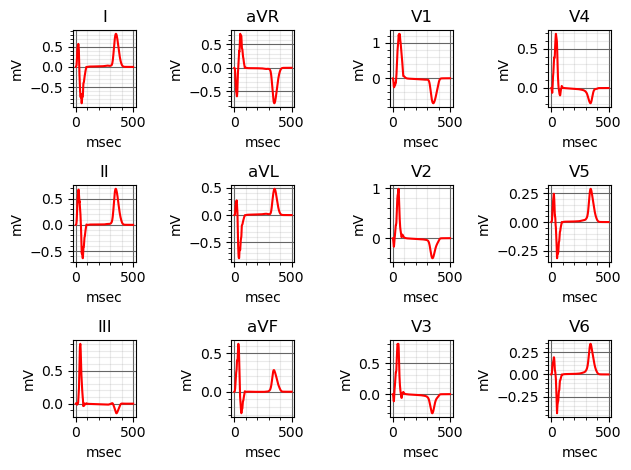

In [6]:
case = 10743
#can make it random number
# randomNumber = random.randint(0,16116)
# print(randomNumber)
# case = randomNumber

print('Case {} : {}'.format(case, file_pairs[case][0]))
pECGData = np.load(file_pairs[case][0])
pECGData = get_standard_leads(pECGData)

# create a figure with 12 subplots
for i in range(pECGData.shape[1]):
    plt.subplot(row, column, reorder[i + 1])
    plt.plot(pECGData[0:num_timesteps,i],'r')
    plt.title(titles[i])
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    plt.xlabel('msec')
    plt.ylabel('mV')
plt.tight_layout()
plt.show()
# close
plt.close()

## Normalized 12 lead pECG graph

Case 10743 : ../intracardiac_dataset/data_hearts_dd_0p2_geo_act_2_bcl/pECGData_hearts_dd_0p2_geo_act_2_bcl_bcl.1000.pattern.11.volunteer.v7.npy
(500, 12)


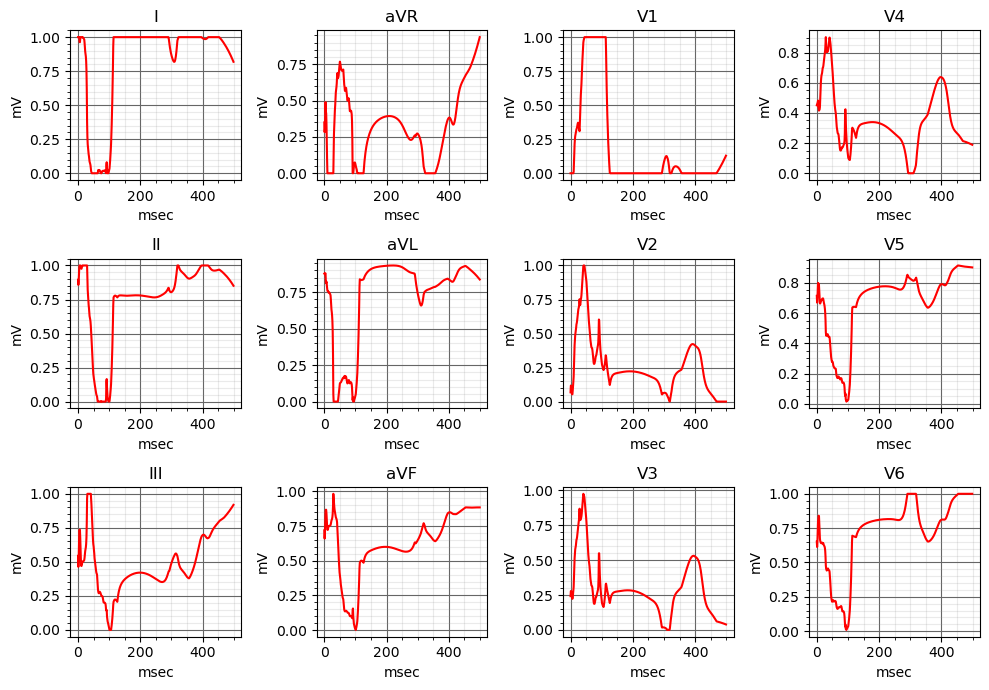

In [7]:
# Example of file pair
plt.figure(figsize=(10, 7))
titles = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
reorder = {1:1,2:5,3:9,4:2,5:6,6:10,7:3,8:7,9:11,10:4,11:8,12:12} # reorder the leads to standard 12-lead ECG display

print('Case {} : {}'.format(case, file_pairs[case][0]))
pECGData = np.load(file_pairs[case][0])
pECGData = get_standard_leads(pECGData)

# normalize ECGData
pECGDataNormalized = normalize_ecg(pECGData)

print(pECGDataNormalized.shape)

# create a figure with 12 subplots
for i in range(pECGDataNormalized.shape[1]):
    plt.subplot(row, column, reorder[i + 1])
    plt.plot(pECGDataNormalized[0:num_timesteps,i],'r')
    plt.title(titles[i])
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    plt.xlabel('msec')
    plt.ylabel('mV')
plt.tight_layout()
plt.show()
# close
plt.close()

## Regular VmData graph

Case 10743 : ../intracardiac_dataset/data_hearts_dd_0p2_geo_act_2_bcl/pECGData_hearts_dd_0p2_geo_act_2_bcl_bcl.1000.pattern.11.volunteer.v7.npy


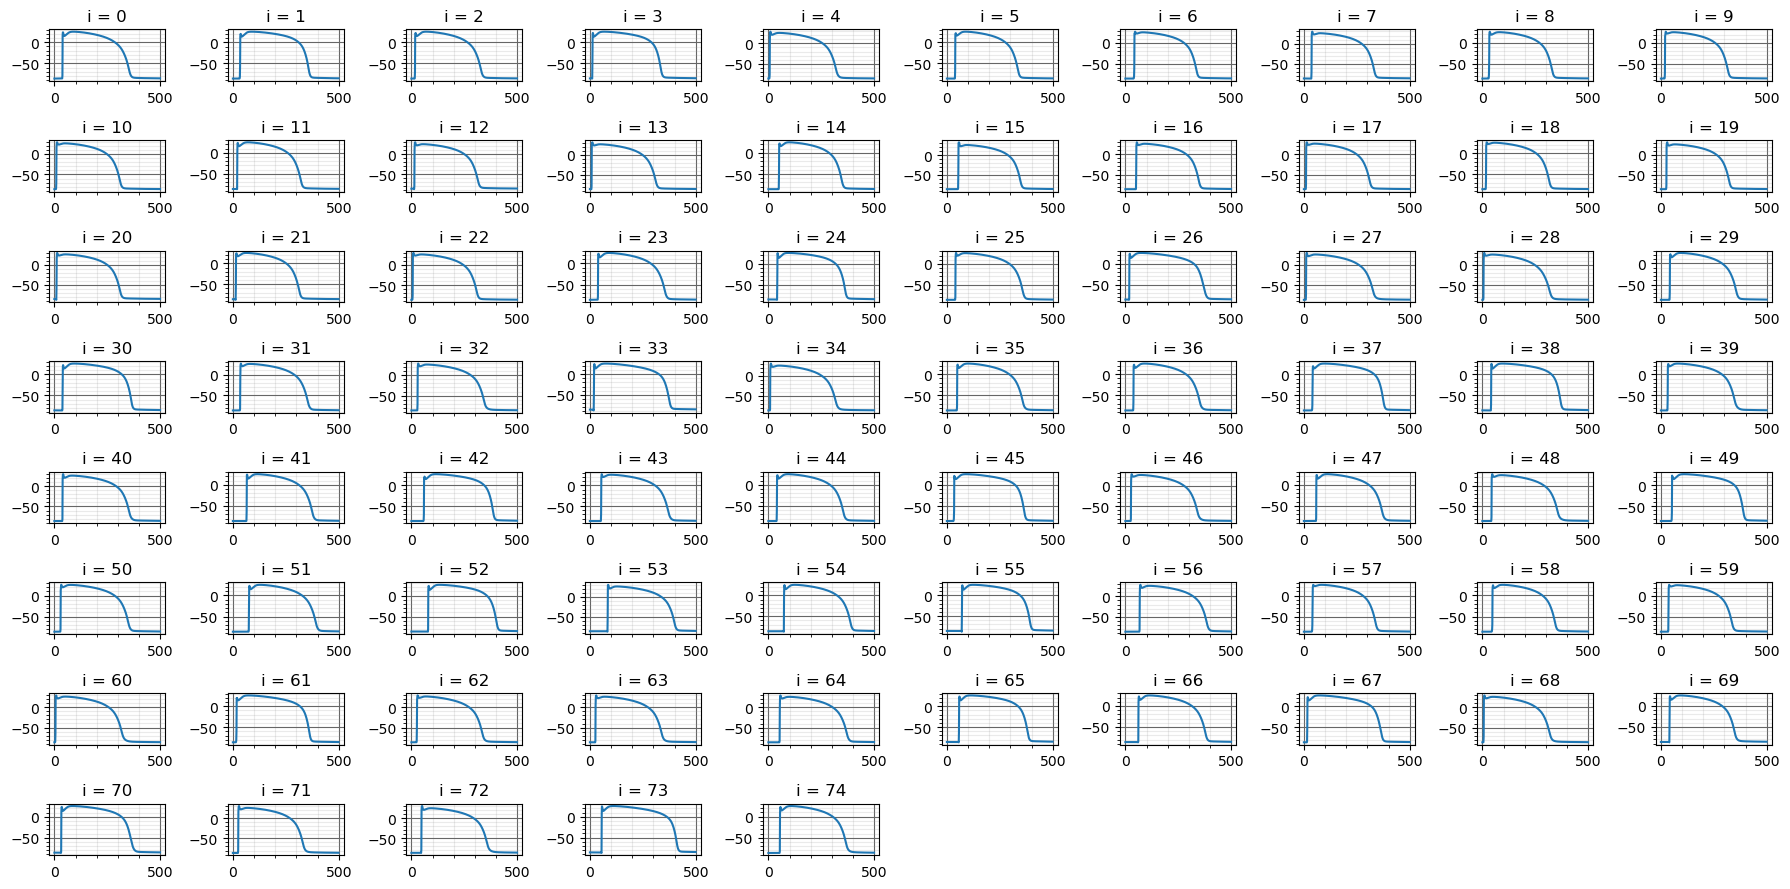

In [8]:
# Example of file pair
# Vm plot
row = 7
column = 10
plt.figure(figsize=(18, 9))

print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = np.load(file_pairs[case][1])

for count, i in enumerate(range(VmData.shape[1])):
    plt.subplot(8, 10, count + 1)
    plt.plot(VmData[0:num_timesteps,i])
    plt.title(f'i = {i}')
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    # plt.xlabel('msec')
    # plt.ylabel('mV')
plt.tight_layout()
plt.show()
# close
plt.close()

## Normalized VmData graphs

Case 10743 : ../intracardiac_dataset/data_hearts_dd_0p2_geo_act_2_bcl/pECGData_hearts_dd_0p2_geo_act_2_bcl_bcl.1000.pattern.11.volunteer.v7.npy
(500, 75)


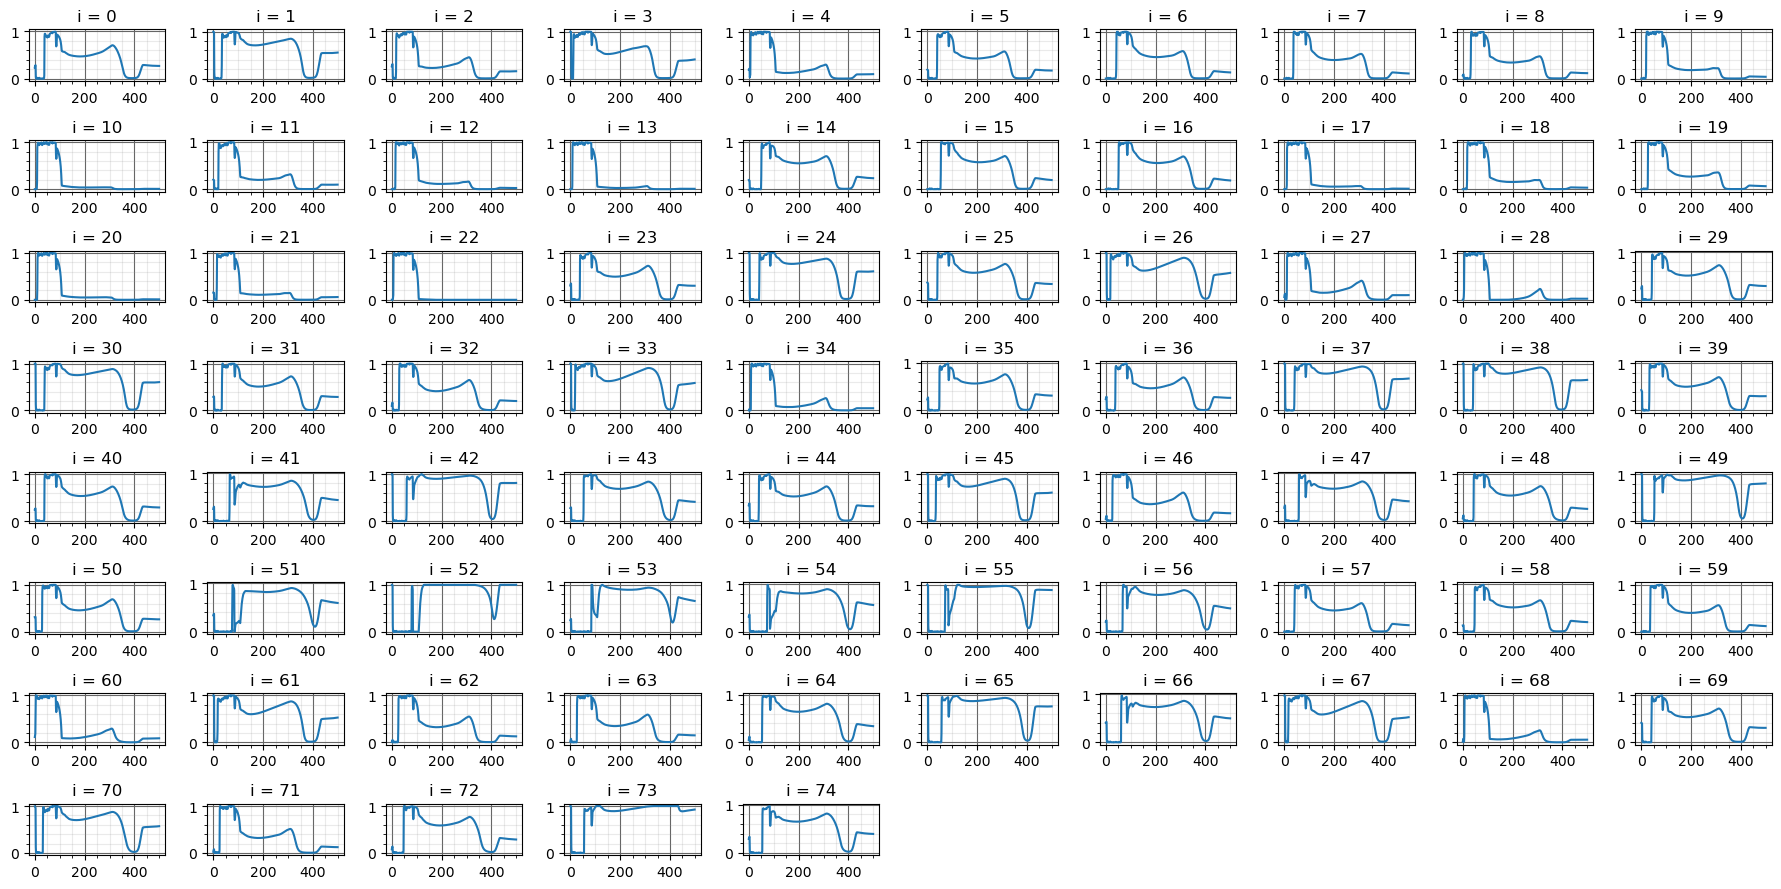

In [9]:
# Example of file pair
# case = 10743
# # Vm plot
plt.figure(figsize=(18, 9))

print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = np.load(file_pairs[case][1])

VmDataNormalized = normalize_ecg(VmData)

print(VmDataNormalized.shape)

for count, i in enumerate(range(VmDataNormalized.shape[1])):
    plt.subplot(8, 10, count + 1)
    plt.plot(VmDataNormalized[0:num_timesteps,i])
    plt.title(f'i = {i}')
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    # plt.xlabel('msec')
    # plt.ylabel('mV')
plt.tight_layout()
plt.show()
# close
plt.close()

## Zoomed out normalized VmData

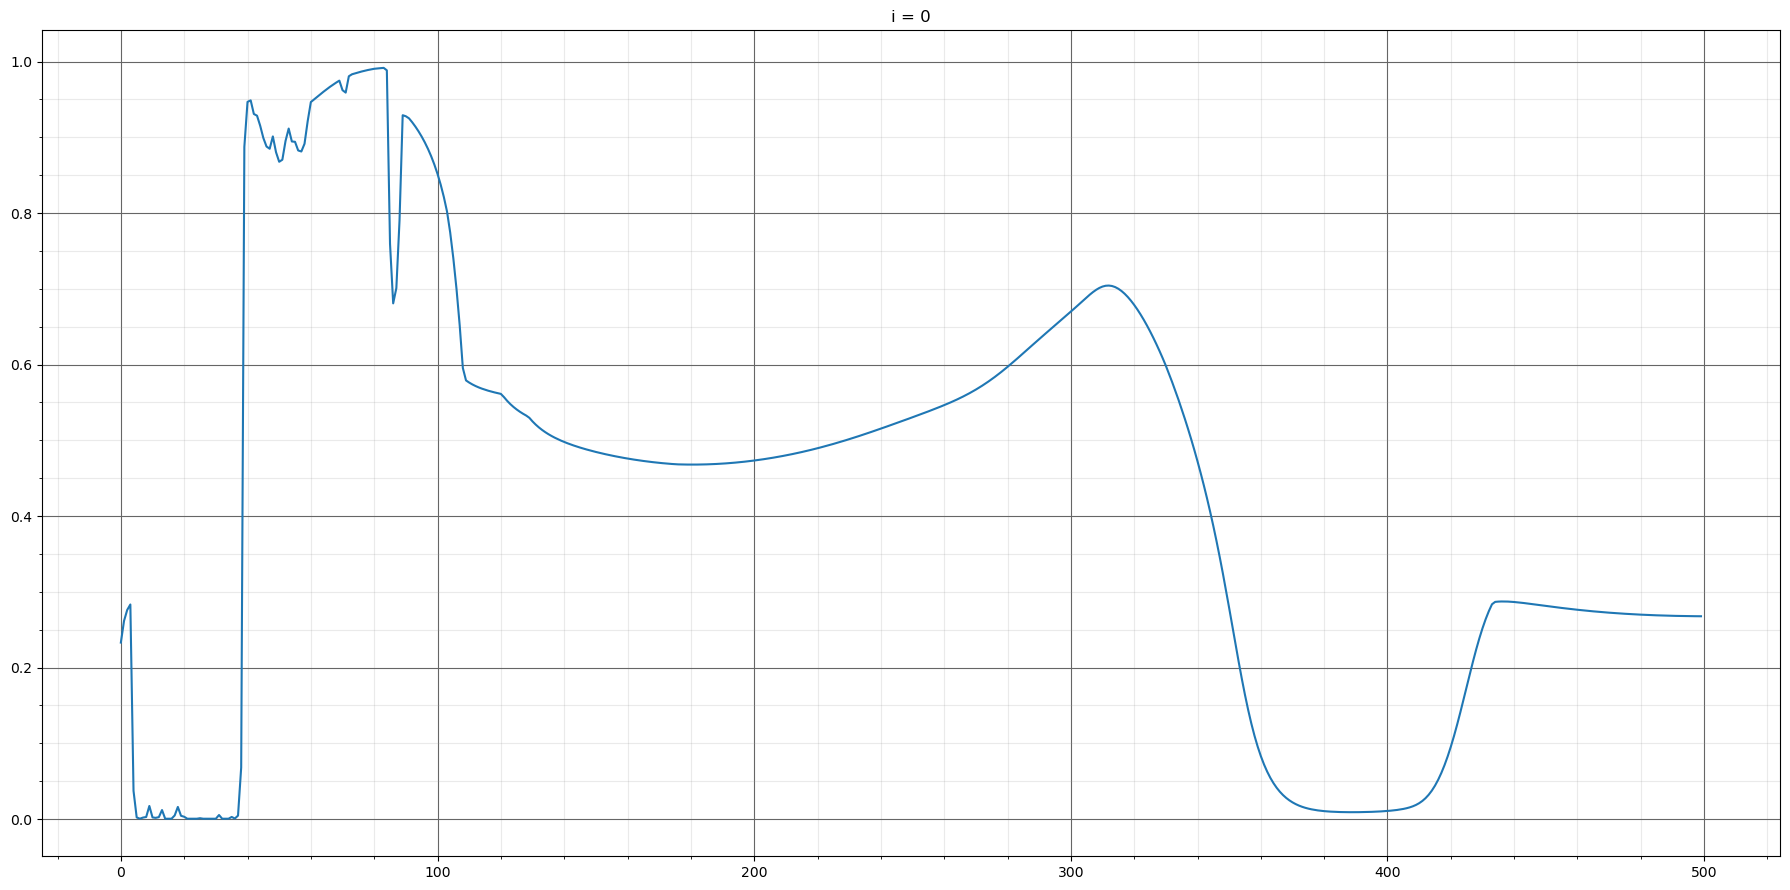

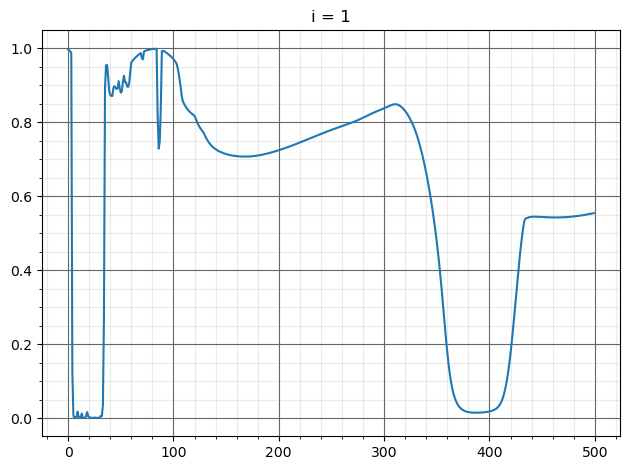

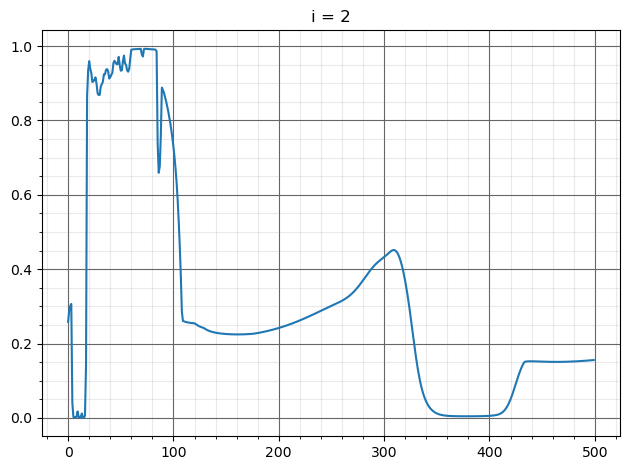

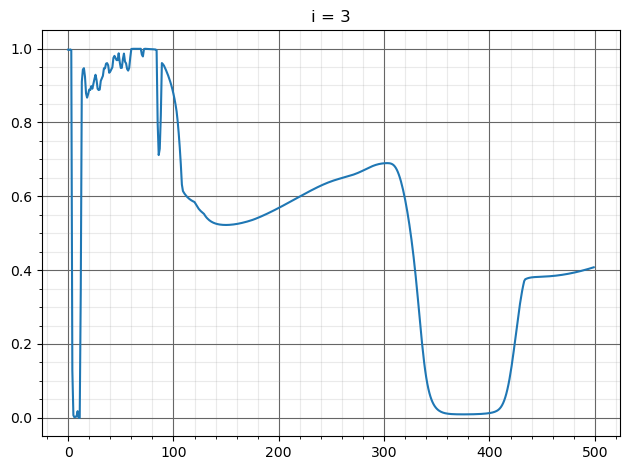

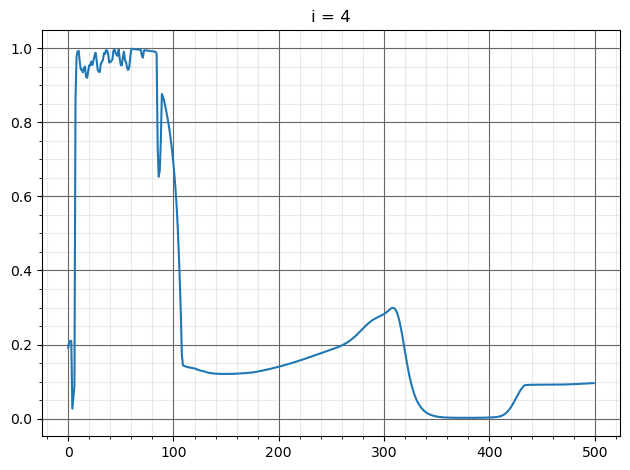

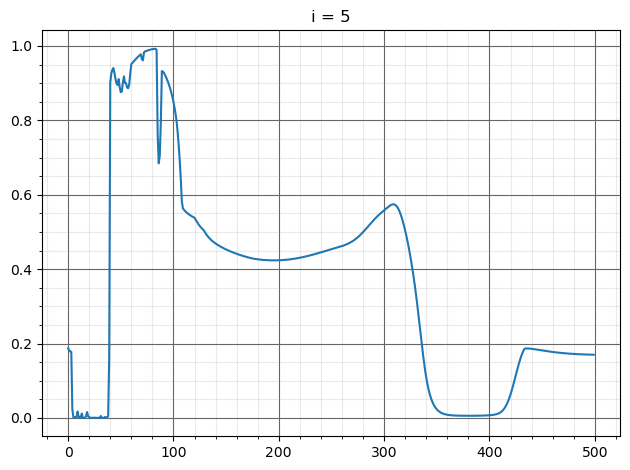

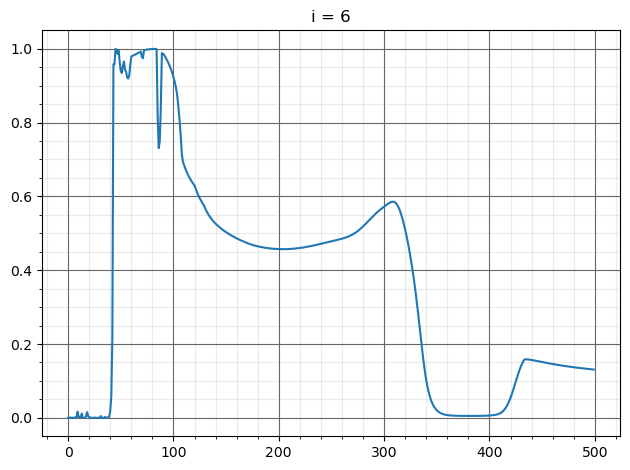

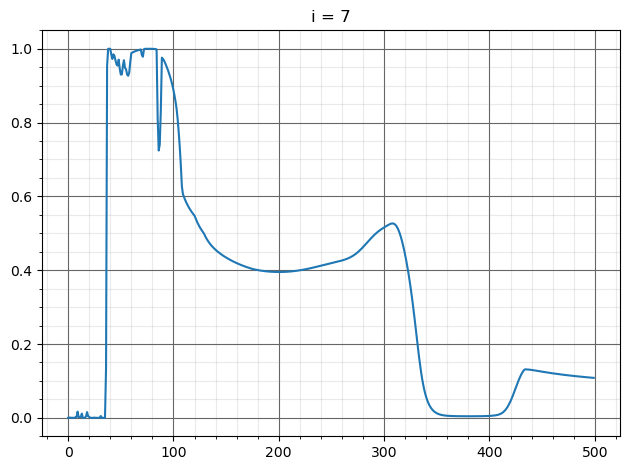

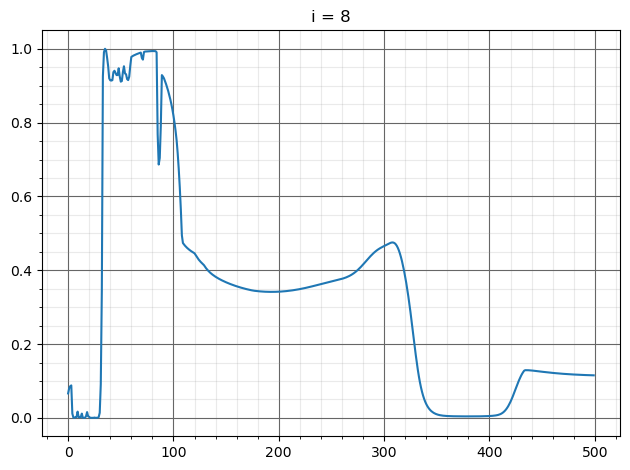

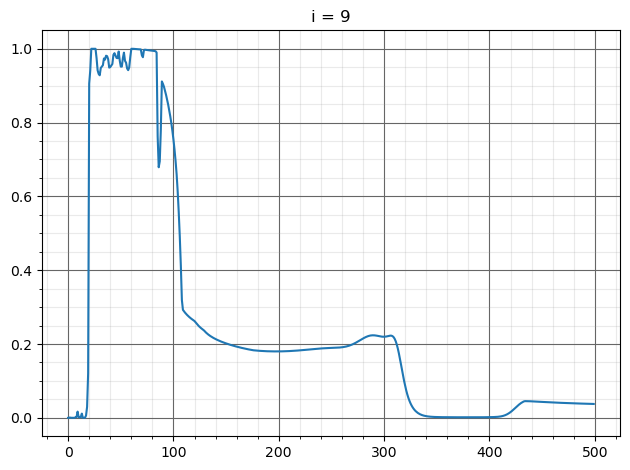

In [10]:
# Example of file pair

# case = 10743
# # Vm plot
# row = 7
# column = 10
plt.figure(figsize=(18, 9))

# print('Case {} : {}'.format(case, file_pairs[case][0]))
# VmData = np.load(file_pairs[case][1])

for i in range(0, 10):
    plt.plot(VmDataNormalized[0:num_timesteps,i])
    plt.title(f'i = {i}')
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    # plt.xlabel('msec')
    # plt.ylabel('mV')
    plt.tight_layout()
    plt.show()
    # close
    plt.close()

## Convert pECG and Vm Data into tensor float

## Getting the activation map from the transmembrane voltages

The funtion `get_activation_map` (in the file `cardiac_ml_tools.py`) is used to obtain the activation map from the transmembrane voltages. It implements the following transformation $A_i = \text{min}_j(V_{ij})$.

Case 10743 : ../intracardiac_dataset/data_hearts_dd_0p2_geo_act_2_bcl/pECGData_hearts_dd_0p2_geo_act_2_bcl_bcl.1000.pattern.11.volunteer.v7.npy
(75, 1)


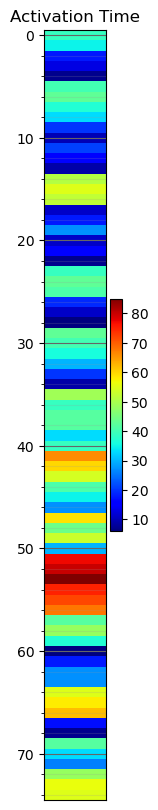

In [11]:
# Example of file pair
case = 10743
plt.figure(figsize=(1, 10))

print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = np.load(file_pairs[case][1])

ActTime = get_activation_time(VmData)

print(ActTime.shape)

# plot the Activation Time array
plt.imshow(ActTime, cmap='jet', interpolation='nearest', aspect='auto')
plt.title('Activation Time')
plt.colorbar()
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
# not xticks
plt.xticks([])
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()


## Task 3: Learning the mapping from the 12-lead ECG to the activation map

Case 213 : ../intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/pECGData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.050.pattern.11.volunteer.v9.npy
Case 213 : ../intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/pECGData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.050.pattern.11.volunteer.v9.npy


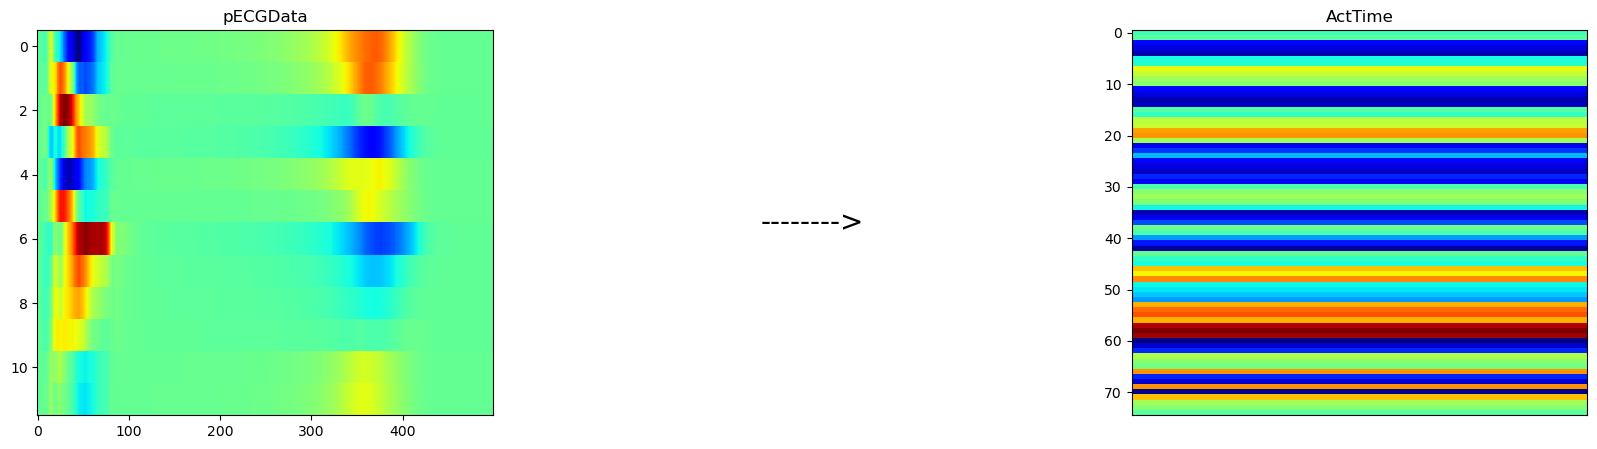

In [12]:
# make a plot with the "pECGData" -> "ActTime"
case = 213

print('Case {} : {}'.format(case, file_pairs[case][0]))
pECGData = np.load(file_pairs[case][0])
pECGData = get_standard_leads(pECGData)

print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = np.load(file_pairs[case][1])
ActTime = get_activation_time(VmData)

# plot in row the tensors pECGData and ActTime with an arrow pointing to the activation time
row = 1
column = 3
plt.figure(figsize=(20, 5))
plt.subplot(row, column, 1)
# plot pECGData transposed
plt.imshow(pECGData.T, cmap='jet', interpolation='nearest', aspect='auto')
plt.title('pECGData')
plt.subplot(row, column, 2)
# print an arrow
plt.text(0.5, 0.5, '-------->', horizontalalignment='center', verticalalignment='center', fontsize=20)
plt.axis('off')
plt.subplot(row, column, 3)
# plot ActTime
plt.imshow(ActTime, cmap='jet', interpolation='nearest', aspect='auto')
# not xticks
plt.xticks([])
plt.title('ActTime')
plt.show()
plt.close()

# Tricks

- As in many machine learning problems, normalization of the data might be helpful or even necessary. Different normalization schemes might be applied.